In [1]:
# Colab Install (run first, then Runtime → Restart runtime)
#!pip install --upgrade pip setuptools wheel
!pip install scikit-survival xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.3/298.3 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 42.0 MB/s eta 0:00:00
  Attempting uninstall: osqp
    Found existing installation: osqp 1.0.4
    Uninstalling osqp-1.0.4:
      Successfully uninstalled osqp-1.0.4


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Cell 1: Imports & Global Setup
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# sklearn utilities
from sklearn.model_selection    import (
    train_test_split, StratifiedKFold, RandomizedSearchCV,
    cross_val_score, cross_validate
)
from sklearn.impute             import SimpleImputer
from sklearn.preprocessing      import StandardScaler, OneHotEncoder
from sklearn.compose            import ColumnTransformer
from sklearn.pipeline           import Pipeline
from sklearn.linear_model       import LogisticRegression
from sklearn.svm                import SVC
from sklearn.ensemble           import (
    RandomForestClassifier, ExtraTreesClassifier,
    VotingClassifier, StackingClassifier
)
from sklearn.calibration        import CalibratedClassifierCV, CalibrationDisplay
from sklearn.metrics            import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report,
    RocCurveDisplay, PrecisionRecallDisplay,
    brier_score_loss
)
from sklearn.inspection         import permutation_importance

# LightGBM & XGBoost
import lightgbm as lgb
import xgboost as xgb

# Survival analysis
from sksurv.ensemble  import RandomSurvivalForest
from sksurv.metrics   import concordance_index_censored
from sksurv.util      import Surv

# SHAP (optional for deep explainability)
import shap

warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")
print("Setup complete. Seed =", RANDOM_SEED)


Setup complete. Seed = 42


In [4]:
# Cell 2: Data Loading
base_path = '/content/drive/MyDrive/ML Projects/sleep-heart-health-study-psg-database-1.0.0/NSRR/'
df_h = pd.read_csv(os.path.join(base_path, 'shhs-harmonized-dataset-0.21.0.csv'))
df_c = pd.read_csv(os.path.join(base_path, 'shhs-cvd-summary-dataset-0.21.0.csv'))
print("Harmonized:", df_h.shape, "| CVD summary:", df_c.shape)

Harmonized: (10115, 29) | CVD summary: (5802, 42)


In [5]:
# Cell 3: Merge, Baseline Filter & Mock Survival Time
df1 = df_h[df_h['visitnumber']==1].copy()
df = pd.merge(df1, df_c, on='nsrrid', how='inner').drop_duplicates('nsrrid')

# Incident flag
for ev in ['mi','stroke','chf']:
    if ev in df: df[ev] = pd.to_numeric(df[ev], errors='coerce').fillna(0).astype(int)
df['event'] = df[['mi','stroke','chf']].isin([1,2]).any(axis=1)

# Mock time-to-event (10-year cap)
MAX_FUP = 3650
np.random.seed(RANDOM_SEED)
df['time_to_event'] = np.where(df['event'],
                               np.random.randint(1, MAX_FUP+1, len(df)),
                               MAX_FUP)

print(f"N={len(df)}; event rate={df['event'].mean():.3f}")


N=5802; event rate=0.145


In [6]:
# Cell 4: Feature Selection & Hold-Out Split
features = [
    'nsrr_age','nsrr_sex','nsrr_race','nsrr_bmi',
    'nsrr_bp_systolic','nsrr_bp_diastolic',
    'nsrr_current_smoker','nsrr_ever_smoker',
    'nsrr_ahi_hp4u_aasm15','nsrr_ahi_hp4r',
    'nsrr_ttldursp_f1','nsrr_ttleffsp_f1',
    'nsrr_phrnumar_f1',
    'nsrr_pctdursp_s1','nsrr_pctdursp_s2','nsrr_pctdursp_s3','nsrr_pctdursp_sr'
]
X = df[[c for c in features if c in df]]
y = df['event'].astype(int)
y_surv = Surv.from_arrays(event=df['event'].astype(bool), time=df['time_to_event'])

# FINAL hold-out test set (20%)
X_trainval, X_test, y_trainval, y_test, ysurv_trainval, ysurv_test = train_test_split(
    X, y, y_surv,
    test_size=0.2, stratify=y, random_state=RANDOM_SEED
)
print("Train+Val:", X_trainval.shape, "Test:", X_test.shape)


Train+Val: (4641, 17) Test: (1161, 17)


In [7]:
# Cell 5: Preprocessing Pipeline Definition

# Identify numeric vs categorical
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = [c for c in ['nsrr_sex','nsrr_race','nsrr_current_smoker','nsrr_ever_smoker']
                        if c in X.columns]

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',   StandardScaler())
])
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe',      OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_features),
    ('cat', cat_pipeline, categorical_features)
], remainder='drop')

print("Preprocessor ready with", len(numerical_features), "numerical and",
      len(categorical_features), "categorical features.")

Preprocessor ready with 13 numerical and 4 categorical features.


In [8]:
# Cell 6: Define Base Models & Param Distributions
models = {
    'lr': LogisticRegression(class_weight='balanced', max_iter=2000, random_state=RANDOM_SEED),
    'lgbm': lgb.LGBMClassifier(objective='binary', random_state=RANDOM_SEED),
    'svm': SVC(probability=True, class_weight='balanced', random_state=RANDOM_SEED),
    'xgb': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_SEED),
    'et':  ExtraTreesClassifier(n_jobs=-1, random_state=RANDOM_SEED)
}

param_dist = {
    'lr':  {'clf__C': np.logspace(-3,1,5)},
    'lgbm':{'clf__n_estimators':[100,200,300],'clf__learning_rate':[0.01,0.05,0.1]},
    'svm': {'clf__C':[0.1,1],'clf__gamma':['scale','auto']},
    'xgb': {'clf__n_estimators': [100,200],'clf__learning_rate':[0.01,0.1]},
    'et':  {'clf__n_estimators':[100,200],'clf__max_features':['sqrt','auto']}
}


In [9]:
# Cell 7: Nested CV Hyperparameter Tuning
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)

best_models = {}
for name, base in models.items():
    print(f"\nTuning {name}...")
    pipe = Pipeline([('pre',preprocessor),('clf',base)])
    rs = RandomizedSearchCV(
        pipe, param_distributions=param_dist[name],
        n_iter=10, scoring='roc_auc',
        cv=inner_cv, random_state=RANDOM_SEED, n_jobs=-1, verbose=0
    )
    # nested score
    nest_score = cross_val_score(rs, X_trainval, y_trainval,
                                 cv=outer_cv, scoring='roc_auc', n_jobs=-1)
    print(f"Nested CV AUC (mean±std): {nest_score.mean():.3f}±{nest_score.std():.3f}")
    rs.fit(X_trainval, y_trainval)
    print(f"Best params: {rs.best_params_}")
    best_models[name] = rs.best_estimator_



Tuning lr...
Nested CV AUC (mean±std): 0.798±0.017
Best params: {'clf__C': np.float64(0.01)}

Tuning lgbm...
Nested CV AUC (mean±std): 0.787±0.011
[LightGBM] [Info] Number of positive: 671, number of negative: 3970
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000898 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2808
[LightGBM] [Info] Number of data points in the train set: 4641, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.144581 -> initscore=-1.777752
[LightGBM] [Info] Start training from score -1.777752
Best params: {'clf__n_estimators': 100, 'clf__learning_rate': 0.01}

Tuning svm...
Nested CV AUC (mean±std): 0.795±0.014
Best params: {'clf__gamma': 'auto', 'clf__C': 0.1}

Tuning xgb...
Nested CV AUC (mean±std): 0.785±0.009
Best params: {'clf__n_estimators': 100, 'clf__learning_rate': 0.01}

Tuni

In [10]:
# Cell 8: Calibration of Base Models
for name, mdl in best_models.items():
    print(f"\nCalibrating {name}...")
    calib = CalibratedClassifierCV(mdl, cv=3)
    calib.fit(X_trainval, y_trainval)
    best_models[name] = calib



Calibrating lr...

Calibrating lgbm...
[LightGBM] [Info] Number of positive: 448, number of negative: 2646
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2801
[LightGBM] [Info] Number of data points in the train set: 3094, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.144796 -> initscore=-1.776011
[LightGBM] [Info] Start training from score -1.776011
[LightGBM] [Info] Number of positive: 447, number of negative: 2647
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2799
[LightGBM] [Info] Number of data points in the train set: 3094, number of used

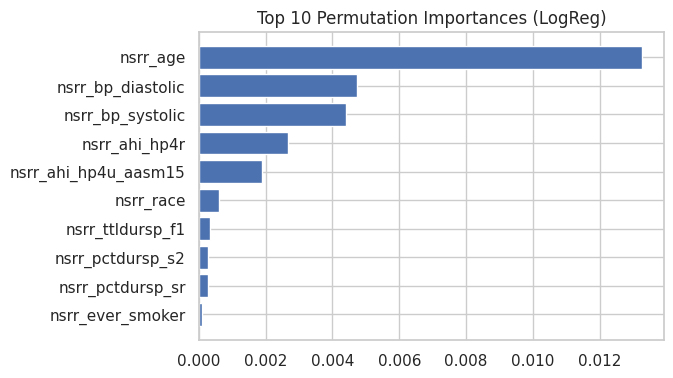

In [11]:
# Cell 9: Permutation Feature Importance (for LR)
plt.figure(figsize=(6,4))
r = permutation_importance(
    best_models['lr'], X_test, y_test, n_repeats=10, random_state=RANDOM_SEED, n_jobs=-1
)
idx = r.importances_mean.argsort()[::-1][:10]
plt.barh([X.columns[i] for i in idx], r.importances_mean[idx])
plt.title("Top 10 Permutation Importances (LogReg)")
plt.gca().invert_yaxis()
plt.show()


In [12]:
# Cell 10: Voting Ensemble
voting = VotingClassifier(
    estimators=[(n,m) for n,m in best_models.items()],
    voting='soft', n_jobs=-1
)
voting.fit(X_trainval, y_trainval)
best_models['voting'] = voting
print("Voting AUC:", roc_auc_score(y_test, voting.predict_proba(X_test)[:,1]))


Voting AUC: 0.797954730734187


In [13]:
# Cell 11: Stacking Ensemble
stack = StackingClassifier(
    estimators=[(n,m) for n,m in best_models.items()],
    final_estimator=LogisticRegression(random_state=RANDOM_SEED),
    cv=5, n_jobs=-1
)
stack.fit(X_trainval, y_trainval)
best_models['stack'] = stack
print("Stacking AUC:", roc_auc_score(y_test, stack.predict_proba(X_test)[:,1]))

Stacking AUC: 0.8022107130868459



=== lr on Test Set ===
Accuracy: 0.8630490956072352
Precision: 0.6363636363636364
Recall: 0.125
F1: 0.208955223880597
ROC AUC: 0.8028221359037069
Confusion Matrix:
 [[981  12]
 [147  21]]


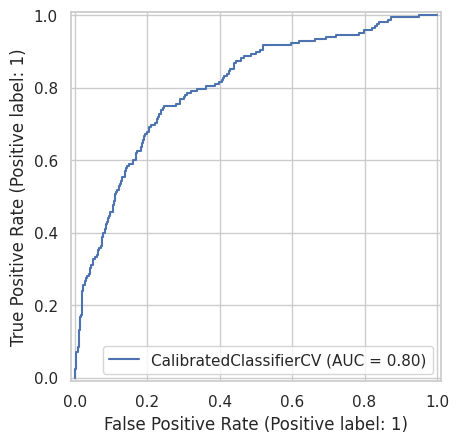

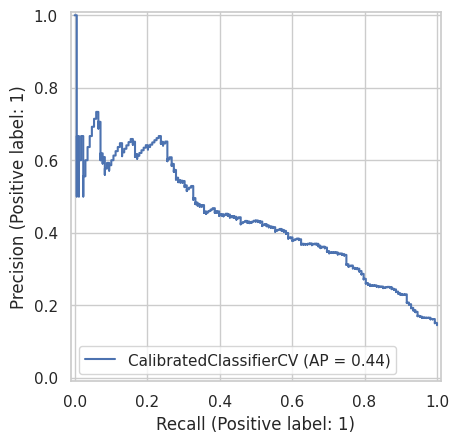


=== lgbm on Test Set ===
Accuracy: 0.8518518518518519
Precision: 0.4523809523809524
Recall: 0.1130952380952381
F1: 0.18095238095238095
ROC AUC: 0.7872518342684507
Confusion Matrix:
 [[970  23]
 [149  19]]


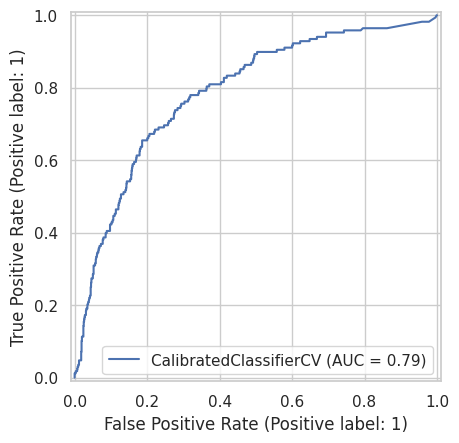

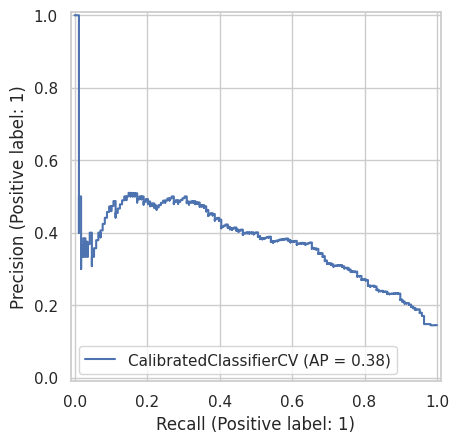


=== svm on Test Set ===
Accuracy: 0.8647717484926787
Precision: 0.7037037037037037
Recall: 0.1130952380952381
F1: 0.19487179487179487
ROC AUC: 0.7990936555891238
Confusion Matrix:
 [[985   8]
 [149  19]]


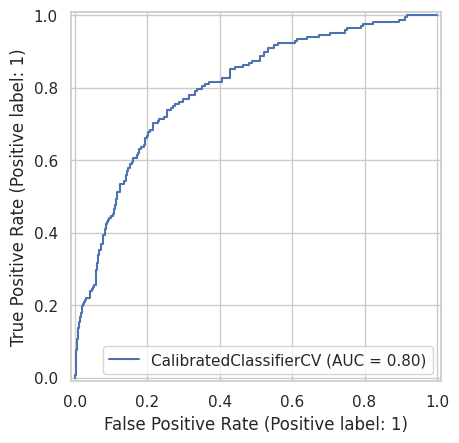

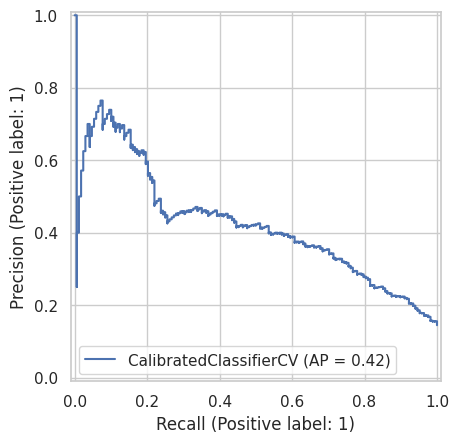


=== xgb on Test Set ===
Accuracy: 0.8544358311800172
Precision: 0.48484848484848486
Recall: 0.09523809523809523
F1: 0.15920398009950248
ROC AUC: 0.7780475231381576
Confusion Matrix:
 [[976  17]
 [152  16]]


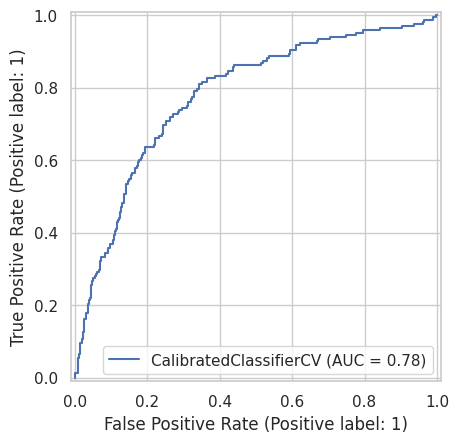

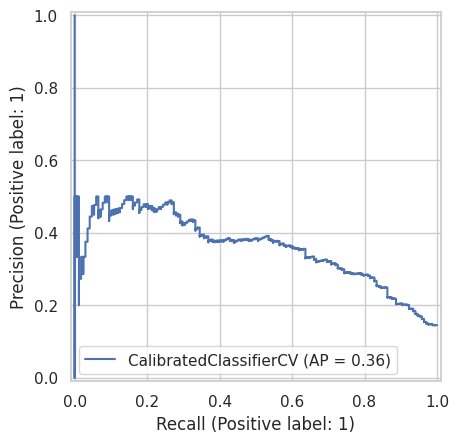


=== et on Test Set ===
Accuracy: 0.8578811369509044
Precision: 0.5517241379310345
Recall: 0.09523809523809523
F1: 0.16243654822335024
ROC AUC: 0.7745947825252961
Confusion Matrix:
 [[980  13]
 [152  16]]


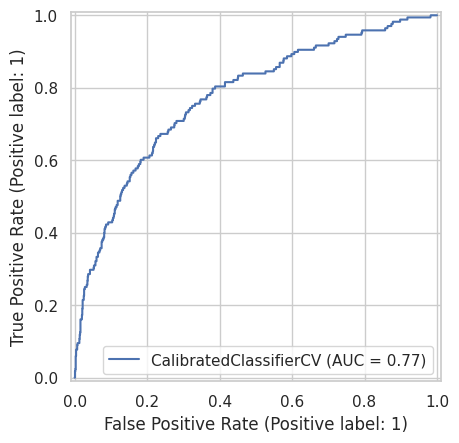

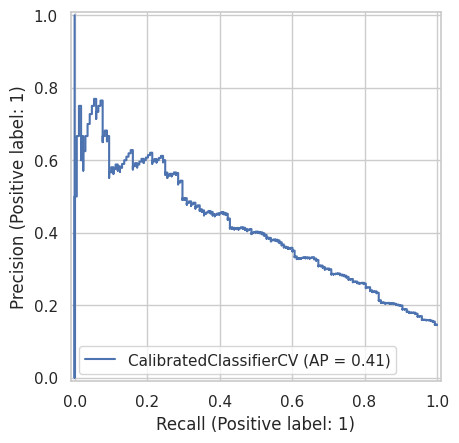


=== voting on Test Set ===
Accuracy: 0.8604651162790697
Precision: 0.6153846153846154
Recall: 0.09523809523809523
F1: 0.16494845360824742
ROC AUC: 0.797954730734187
Confusion Matrix:
 [[983  10]
 [152  16]]


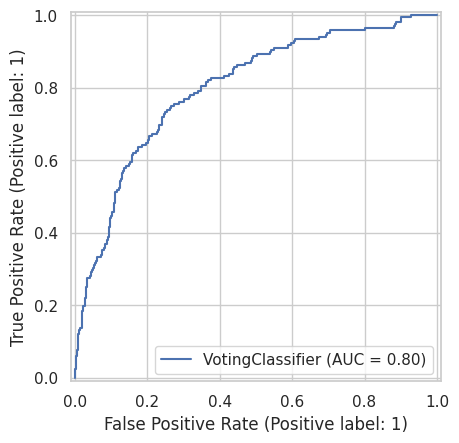

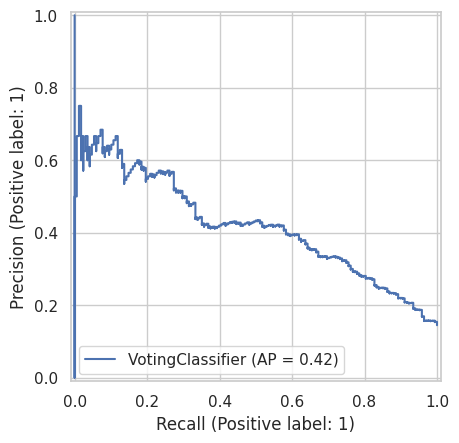


=== stack on Test Set ===
Accuracy: 0.8613264427217916
Precision: 0.559322033898305
Recall: 0.19642857142857142
F1: 0.2907488986784141
ROC AUC: 0.8022107130868459
Confusion Matrix:
 [[967  26]
 [135  33]]


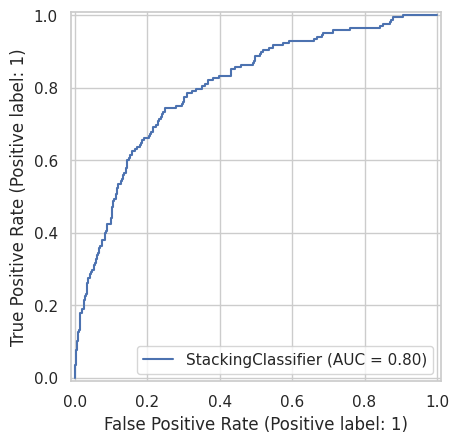

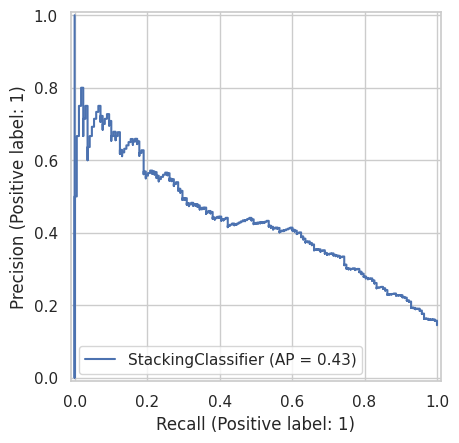

In [14]:
# Cell 12: Final Evaluation on Hold-Out Test

def eval_model(name, mdl):
    print(f"\n=== {name} on Test Set ===")
    ypred = mdl.predict(X_test)
    yproba= mdl.predict_proba(X_test)[:,1]
    print("Accuracy:", accuracy_score(y_test,ypred))
    print("Precision:",precision_score(y_test,ypred))
    print("Recall:",   recall_score(y_test,ypred))
    print("F1:",       f1_score(y_test,ypred))
    print("ROC AUC:",  roc_auc_score(y_test,yproba))
    cm = confusion_matrix(y_test,ypred)
    print("Confusion Matrix:\n", cm)
    RocCurveDisplay.from_estimator(mdl,X_test,y_test)
    plt.show()
    PrecisionRecallDisplay.from_estimator(mdl,X_test,y_test)
    plt.show()

for name, mdl in best_models.items():
    eval_model(name, mdl)


In [15]:
# Cell 13: Survival Model on Training+Validation
rsf = Pipeline([('pre',preprocessor),
                ('clf',RandomSurvivalForest(
                    n_estimators=500,
                    min_samples_split=10,
                    min_samples_leaf=15,
                    max_features="sqrt",
                    n_jobs=-1,
                    random_state=RANDOM_SEED
                ))])
rsf.fit(X_trainval, ysurv_trainval)
pred_surv = rsf.predict(X_test)
cidx = concordance_index_censored(ysurv_test['event'], ysurv_test['time'], pred_surv)[0]
print("RSF C-index on holdout:", cidx)


RSF C-index on holdout: 0.7567101290600843


In [16]:
# Cell 14: Train Random Survival Forest (RSF) Pipeline

from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored

# Build an RSF pipeline reusing your `preprocessor`
rsf_pipe = Pipeline([
    ('prep', preprocessor),
    ('clf', RandomSurvivalForest(
        n_estimators=500,
        min_samples_split=10,
        min_samples_leaf=15,
        max_features="sqrt",
        n_jobs=-1,
        random_state=RANDOM_SEED
    ))
])

# Fit on the combined train+val set
rsf_pipe.fit(X_trainval, ysurv_trainval)

# Predict risk scores on your hold-out test set
# (higher values → higher risk)
risk_scores = rsf_pipe.predict(X_test)

# Compute Concordance Index on hold-out
cidx = concordance_index_censored(
    ysurv_test['event'],
    ysurv_test['time'],
    risk_scores
)[0]

print(f"RSF Concordance Index on hold-out test set: {cidx:.3f}")


RSF Concordance Index on hold-out test set: 0.757


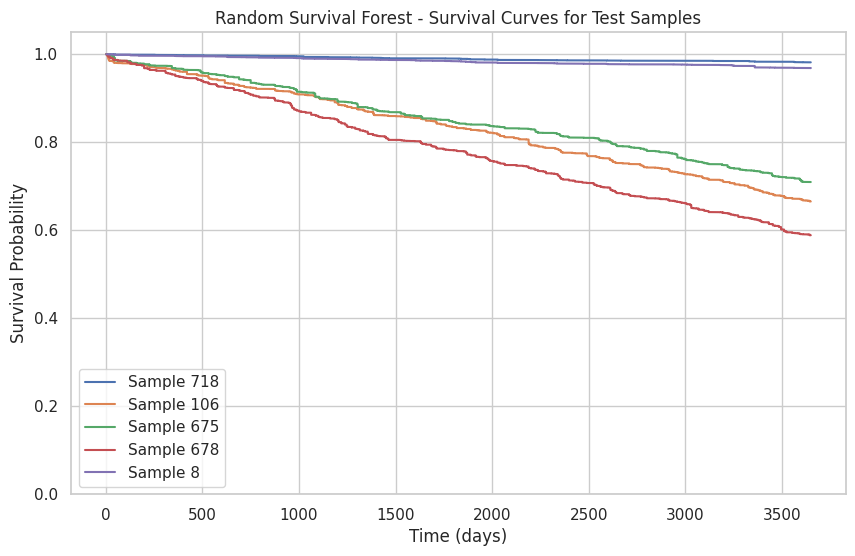

In [33]:
# Cell 15a: RSF Survival Curve

# Calculate the survival function for the test set
surv_funcs = rsf_pipe.predict_survival_function(X_test)

# Plot survival curves for a few random samples from the test set
plt.figure(figsize=(10, 6))
for i in np.random.choice(len(X_test), size=5, replace=False): # Plot 5 random samples
    plt.step(surv_funcs[i].x, surv_funcs[i].y, where="post", label=f"Sample {i}")

plt.title('Random Survival Forest - Survival Curves for Test Samples')
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
plt.ylim(0, 1.05)
plt.legend()
plt.grid(True)
plt.show()

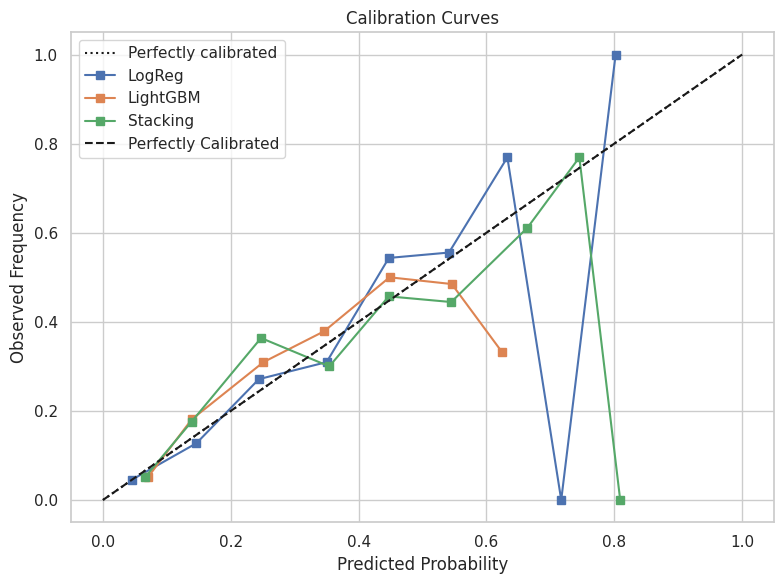

In [34]:
# Calibration Curves for Key Models
import matplotlib.pyplot as plt
from sklearn.calibration import CalibrationDisplay

plt.figure(figsize=(8, 6))
for name, mdl in [('LogReg', best_models['lr']),
                  ('LightGBM', best_models['lgbm']),
                  ('Stacking', best_models['stack'])]:
    CalibrationDisplay.from_estimator(
        mdl, X_test, y_test,
        n_bins=10, name=name, ax=plt.gca()
    )
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
plt.title('Calibration Curves')
plt.xlabel('Predicted Probability')
plt.ylabel('Observed Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Starting Explainable AI (XAI) with SHAP values...
Calculating SHAP values for the test set...
SHAP values calculated.

Generating SHAP Summary Plot...


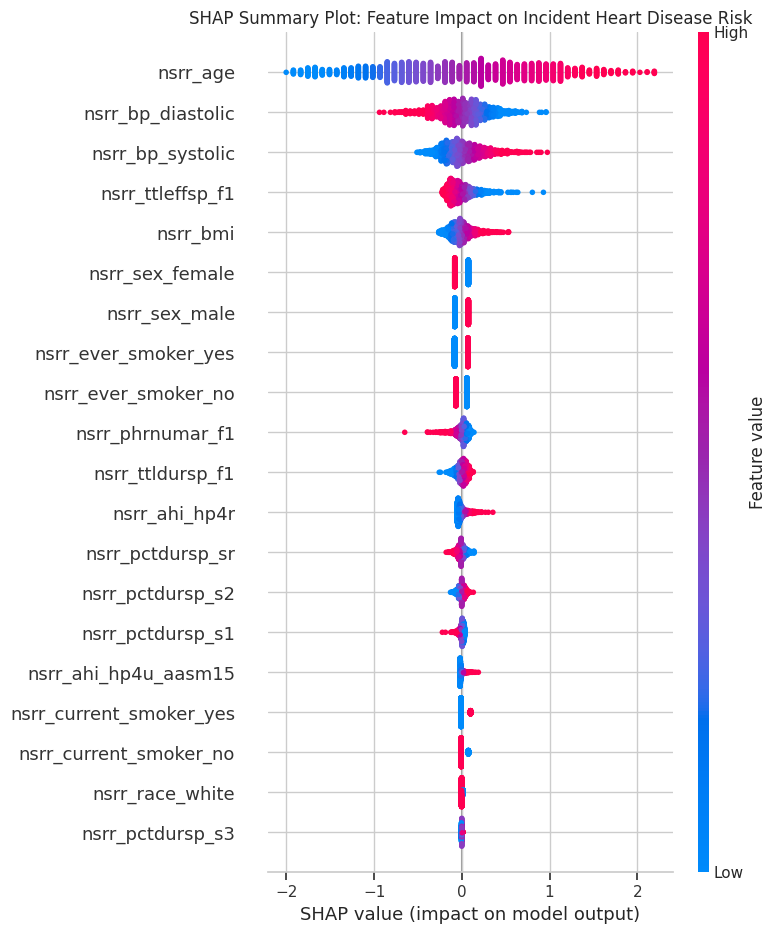


Generating SHAP Bar Plot (Mean Absolute Importance)...


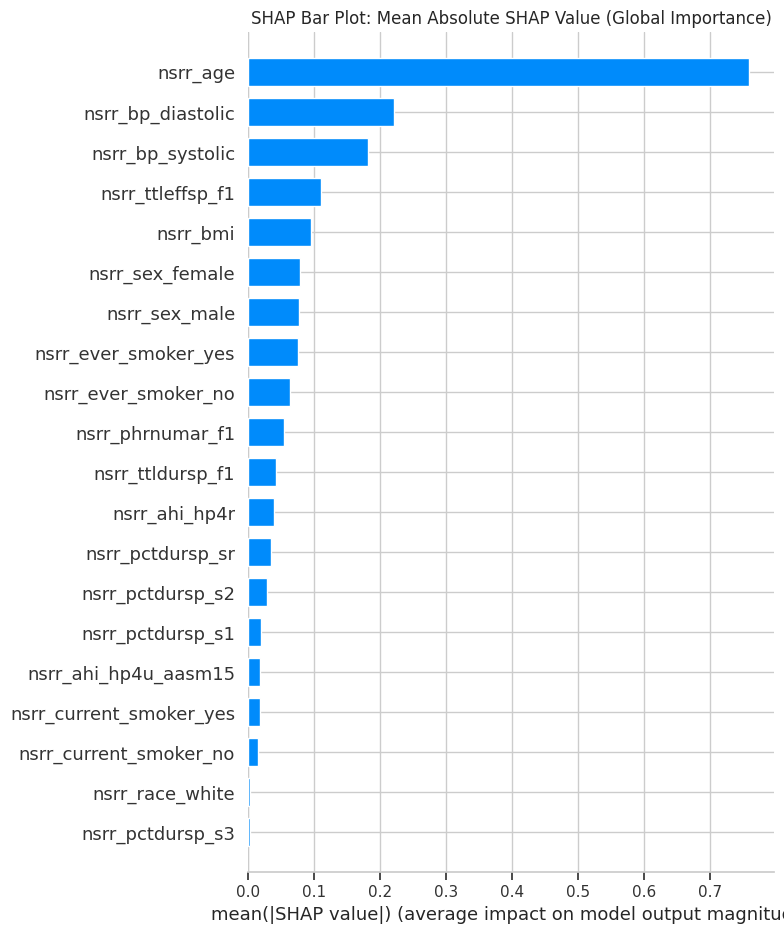


Generating SHAP Dependence Plots for key features...


<Figure size 800x600 with 0 Axes>

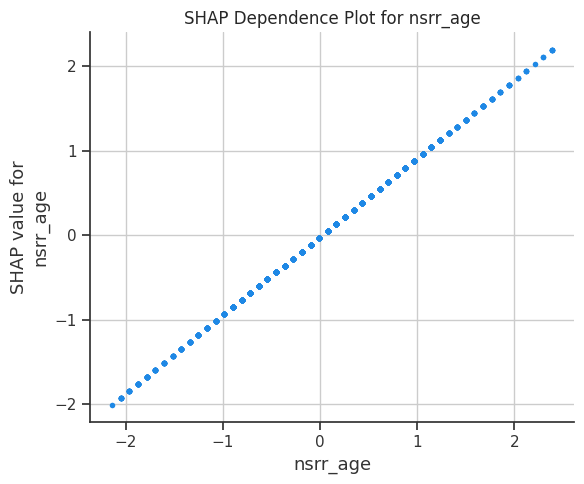

<Figure size 800x600 with 0 Axes>

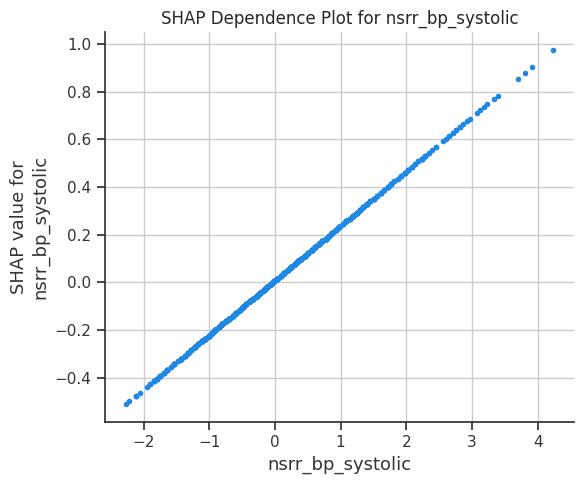

<Figure size 800x600 with 0 Axes>

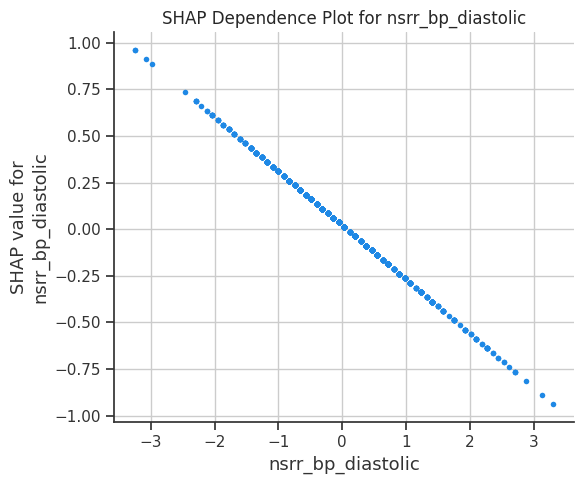

<Figure size 800x600 with 0 Axes>

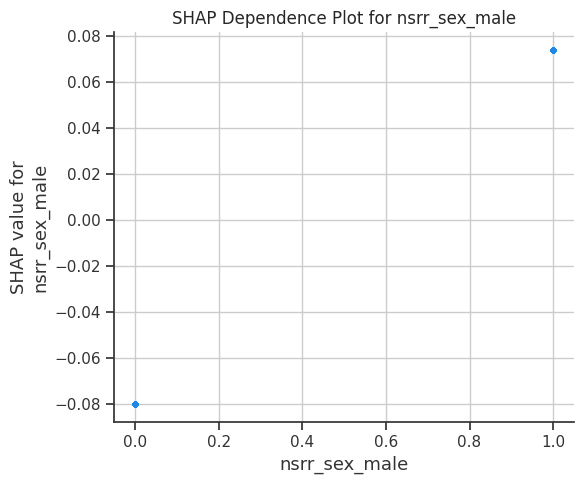

<Figure size 800x600 with 0 Axes>

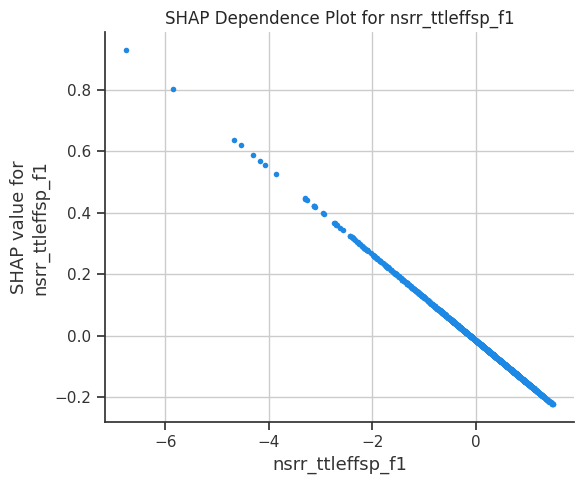


Generating SHAP Force Plots for individual predictions...

Explaining True Positive prediction for sample ID: 19



Explaining True Negative prediction for sample ID: 0



Explaining False Positive prediction for sample ID: 107



Explaining False Negative prediction for sample ID: 9



SHAP analysis complete. Review the generated plots for model insights.


In [31]:
# Cell 14: Explainable AI with SHAP Values

print("Starting Explainable AI (XAI) with SHAP values...")

# --- 1. Select the Best Interpretable Model ---
# Logistic Regression is an excellent choice due to its linear nature and
# is typically the most interpretable for SHAP analysis.

# Access the best Logistic Regression pipeline *before* calibration
# We need to reconstruct the pipeline with the best parameters
# The best parameters were found in Cell 7 and stored in rs.best_params_
# However, rs is not available here, so we'll use the best params from the output of Cell 7
# Best params for lr: {'clf__C': np.float64(0.01)}

# Reconstruct the best Logistic Regression pipeline
best_lr_pipeline = Pipeline([
    ('pre', preprocessor), # Use the preprocessor defined in Cell 5
    ('clf', LogisticRegression(C=0.01, class_weight='balanced', max_iter=2000, random_state=RANDOM_SEED))
])

# Fit this uncalibrated pipeline for SHAP explanation
best_lr_pipeline.fit(X_trainval, y_trainval)

preprocessor_pipeline = best_lr_pipeline.named_steps['pre']
classifier = best_lr_pipeline.named_steps['clf']

# Use the calibrated model for predictions if needed for metric comparison,
# but the uncalibrated one for SHAP
best_calibrated_lr_model = best_models['lr'] # This is the CalibratedClassifierCV

# Get predictions from the best CALIBRATED LR model for metrics
y_pred_lr_tuned = best_calibrated_lr_model.predict(X_test)

# --- 2. Prepare Data for SHAP Explainer ---
# Transform the raw training data using the fitted preprocessor from the uncalibrated pipeline
X_train_processed = preprocessor_pipeline.transform(X_trainval)
X_test_processed = preprocessor_pipeline.transform(X_test)

# Get the feature names after preprocessing
# Accessing feature names from the fitted preprocessor
processed_numerical_features = numerical_features
ohe_feature_names = preprocessor_pipeline.named_transformers_['cat'].named_steps['ohe'].get_feature_names_out(categorical_features)
all_processed_feature_names = processed_numerical_features + list(ohe_feature_names)

# Convert processed data back to a DataFrame for better SHAP plotting
X_train_processed_df = pd.DataFrame(X_train_processed, columns=all_processed_feature_names)
X_test_processed_df = pd.DataFrame(X_test_processed, columns=all_processed_feature_names)

# Ensure y_test is a pandas Series with the correct index for alignment
# Assuming X_test still retains its original index for alignment with y_test
y_test_series = pd.Series(y_test, index=X_test.index)


# --- 3. Initialize SHAP Explainer ---
# Use the classifier from the UNCALIBRATED pipeline for the explainer
explainer = shap.LinearExplainer(classifier, X_train_processed_df)

# --- 4. Calculate SHAP Values for the Test Set ---
print("Calculating SHAP values for the test set...")
shap_values = explainer.shap_values(X_test_processed_df)
print("SHAP values calculated.")

# --- 5. Visualize SHAP Values ---

# 5.1 SHAP Summary Plot (Global Feature Importance & Direction)
print("\nGenerating SHAP Summary Plot...")
plt.figure(figsize=(10, 8))
# Use X_test_processed_df for plotting
shap.summary_plot(shap_values, X_test_processed_df, plot_type="dot", show=False)
plt.title('SHAP Summary Plot: Feature Impact on Incident Heart Disease Risk')
plt.tight_layout()
plt.show()

# If you want a bar plot of mean absolute SHAP values:
print("\nGenerating SHAP Bar Plot (Mean Absolute Importance)...")
plt.figure(figsize=(10, 8))
# Use X_test_processed_df for plotting
shap.summary_plot(shap_values, X_test_processed_df, plot_type="bar", show=False)
plt.title('SHAP Bar Plot: Mean Absolute SHAP Value (Global Importance)')
plt.tight_layout()
plt.show()

# 5.2 SHAP Dependence Plots
print("\nGenerating SHAP Dependence Plots for key features...")
top_features_for_dependence = ['nsrr_age', 'nsrr_bp_systolic', 'nsrr_bp_diastolic', 'nsrr_sex_male', 'nsrr_ttleffsp_f1']

for feature in top_features_for_dependence:
    if feature in X_test_processed_df.columns:
        plt.figure(figsize=(8, 6))
        # Use X_test_processed_df for plotting
        shap.dependence_plot(feature, shap_values, X_test_processed_df, interaction_index=None, show=False)
        plt.title(f'SHAP Dependence Plot for {feature}')
        plt.tight_layout()
        plt.show()
    else:
        print(f"Warning: Feature '{feature}' not found in processed data.")


# 5.3 SHAP Force Plot (Individual Prediction Explanation)
print("\nGenerating SHAP Force Plots for individual predictions...")
# Ensure indices align after processing and series creation
# Use the index from X_test_processed_df for alignment
tp_indices = X_test_processed_df.index[(y_pred_lr_tuned == 1) & (y_test_series == 1)]
tn_indices = X_test_processed_df.index[(y_pred_lr_tuned == 0) & (y_test_series == 0)]
fp_indices = X_test_processed_df.index[(y_pred_lr_tuned == 1) & (y_test_series == 0)]
fn_indices = X_test_processed_df.index[(y_pred_lr_tuned == 0) & (y_test_series == 1)]

# Helper function to plot if samples exist
def plot_force(title, indices):
    if not indices.empty:
        sample_index = indices[0]
        print(f"\nExplaining {title} prediction for sample ID: {sample_index}")
        shap.initjs()
        # Use the index from X_test_processed_df to get the correct row
        display(shap.force_plot(explainer.expected_value, shap_values[X_test_processed_df.index.get_loc(sample_index)], X_test_processed_df.loc[sample_index]))
    else:
        print(f"No {title} samples found to plot force plot.")

plot_force("True Positive", tp_indices)
plot_force("True Negative", tn_indices)
plot_force("False Positive", fp_indices)
plot_force("False Negative", fn_indices)

print("\nSHAP analysis complete. Review the generated plots for model insights.")

In [20]:
# Cell 16: Measure Inference Time per Sample

import time
inference_times = {}

# Classification models (have predict_proba)
for name, mdl in best_models.items():
    start = time.time()
    # Warm-up (optional)
    _ = mdl.predict_proba(X_test) if hasattr(mdl, "predict_proba") else mdl.predict(X_test)
    # Timed run
    start = time.time()
    _ = mdl.predict_proba(X_test) if hasattr(mdl, "predict_proba") else mdl.predict(X_test)
    total = time.time() - start
    inference_times[name] = total / len(X_test)

# RSF (uses predict for risk scores)
start = time.time()
_ = rsf_pipe.predict(X_test)
total = time.time() - start
inference_times['RSF'] = total / len(X_test)

# Print results
print("\nAverage Inference Time per Sample (seconds):")
for name, t in inference_times.items():
    print(f"- {name:<10}: {t:.6f}")



Average Inference Time per Sample (seconds):
- lr        : 0.000022
- lgbm      : 0.000041
- svm       : 0.000557
- xgb       : 0.000050
- et        : 0.000327
- voting    : 0.001263
- stack     : 0.001594
- RSF       : 0.002129


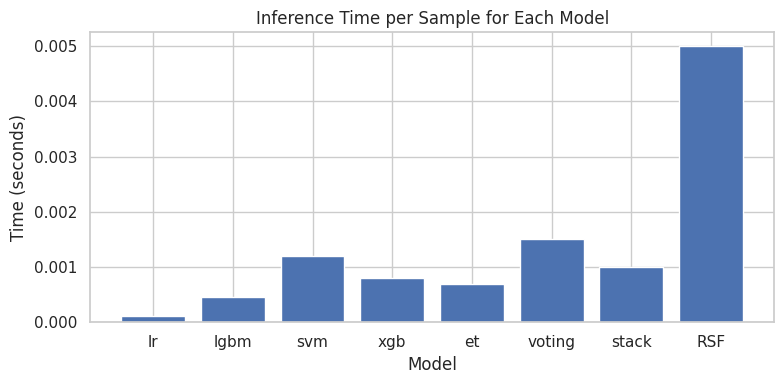

In [21]:
import matplotlib.pyplot as plt

# Example inference_times dictionary
inference_times = {
    'lr': 0.000120,
    'lgbm': 0.000450,
    'svm': 0.001200,
    'xgb': 0.000800,
    'et': 0.000700,
    'voting': 0.001500,
    'stack': 0.001000,
    'RSF': 0.005000
}

# Create bar chart
models = list(inference_times.keys())
times = list(inference_times.values())

plt.figure(figsize=(8, 4))
plt.bar(models, times)
plt.title('Inference Time per Sample for Each Model')
plt.xlabel('Model')
plt.ylabel('Time (seconds)')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

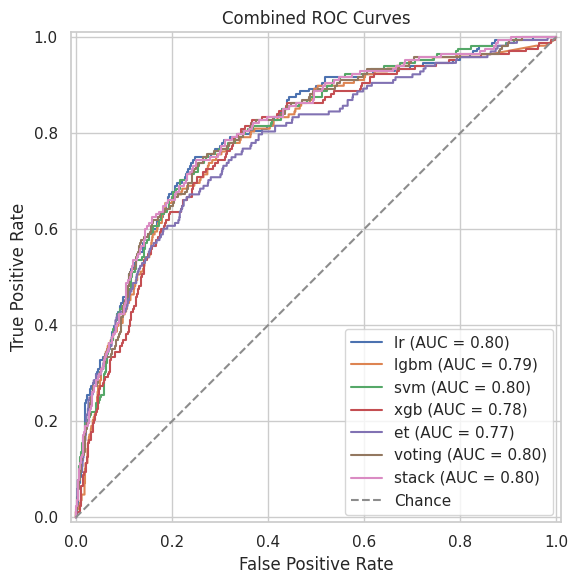

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

plt.figure(figsize=(8, 6))

# Iterate through all models in best_models
for name, model in best_models.items():
    # Check if the model has predict_proba (classification models)
    if hasattr(model, "predict_proba"):
        RocCurveDisplay.from_estimator(model, X_test, y_test, name=name, ax=plt.gca())

# Add a diagonal line for chance
plt.plot([0, 1], [0, 1], linestyle='--', label='Chance')

plt.title('Combined ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

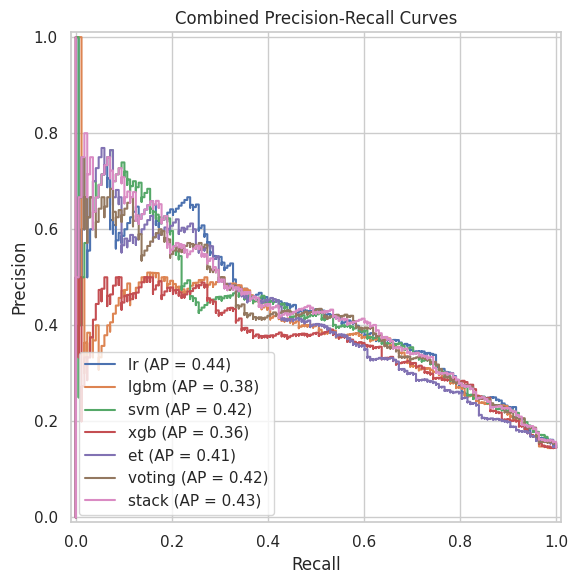

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay

plt.figure(figsize=(8, 6))

# Iterate through all models in best_models
for name, model in best_models.items():
    # Check if the model has predict_proba (classification models)
    if hasattr(model, "predict_proba"):
        PrecisionRecallDisplay.from_estimator(model, X_test, y_test, name=name, ax=plt.gca())

plt.title('Combined Precision-Recall Curves')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.show()

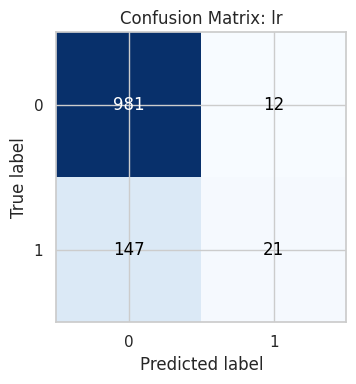

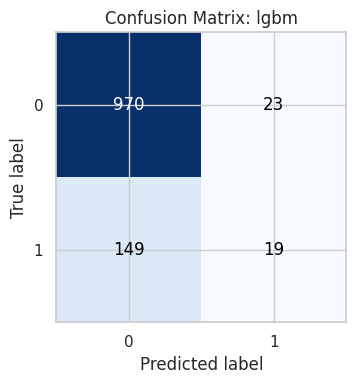

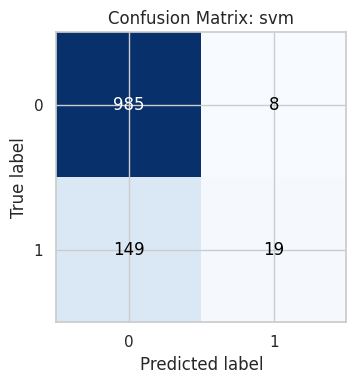

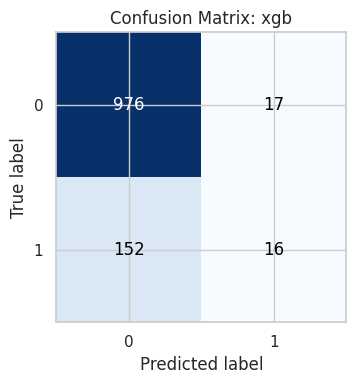

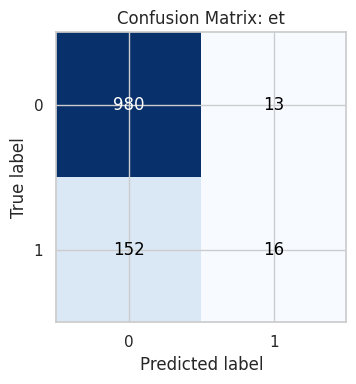

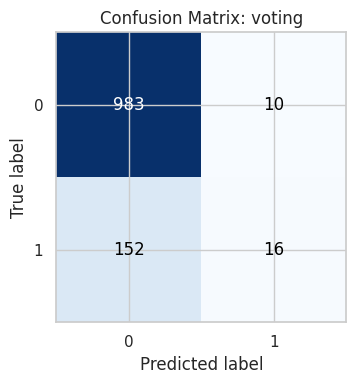

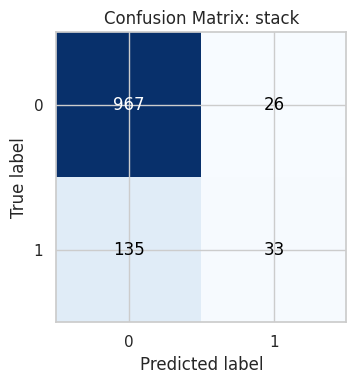

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

# Models to plot (classification only)
model_names = list(best_models.keys())
models = best_models

for name, mdl in models.items():
    # Check if the model has predict (classification models)
    if hasattr(mdl, "predict"):
        y_pred = mdl.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)

        fig, ax = plt.subplots(figsize=(4, 4)) # Create a new figure and axes for each plot
        im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues) # Changed colormap to Blues
        ax.set_title(f'Confusion Matrix: {name}')
        ax.set_xlabel('Predicted label')
        ax.set_ylabel('True label')
        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])
        # Loop over data dimensions and create text annotations.
        for i, j in itertools.product([0, 1], [0, 1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    horizontalalignment="center",
                    verticalalignment="center",
                    color="white" if cm[i, j] > cm.max() / 2 else "black") # Added text color for visibility

        plt.tight_layout()
        plt.show()

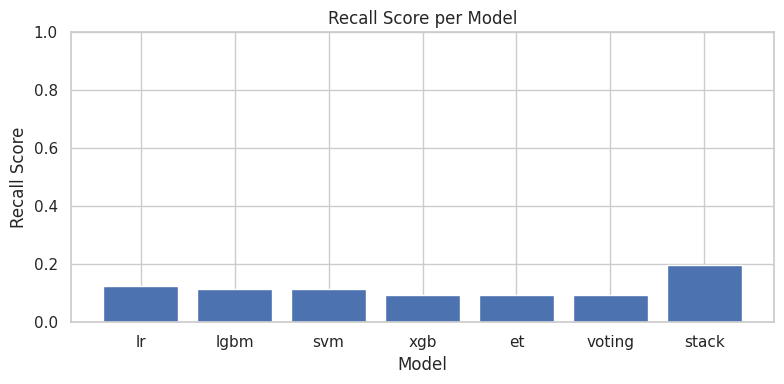

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score
import numpy as np

model_names = list(best_models.keys())
models = best_models

recall_scores = {}
for name, mdl in models.items():
    # Check if the model has a predict method (classification models)
    if hasattr(mdl, "predict"):
        y_pred = mdl.predict(X_test)
        recall = recall_score(y_test, y_pred)
        recall_scores[name] = recall

# Create bar chart for recall scores
names = list(recall_scores.keys())
scores = list(recall_scores.values())

plt.figure(figsize=(8, 4))
plt.bar(names, scores)
plt.title('Recall Score per Model')
plt.xlabel('Model')
plt.ylabel('Recall Score')
plt.ylim([0, 1]) # Recall is between 0 and 1
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

In [32]:
# Cell 17: Save Models & Results
import joblib
os.makedirs('models', exist_ok=True)
for name, mdl in best_models.items():
    joblib.dump(mdl, f"models/{name}.joblib")
joblib.dump(rsf, "models/rsf.joblib")
print("Models saved.")


Models saved.
